# 这是固定极值的部分

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_toy_dataset(
    N,
    T=200,
    seed=0,
    # trend
    trend_a_range=(0.8, 1.2),     # 上升幅度 a > 0
    trend_b_range=(-0.2, 0.2),    # 起始偏置 b
    # seasonality: 3 个中频 bins
    season_bins=(5, 8, 11),
    season_A_range=(0.12, 0.30),  # 每个分量幅度随机
    # extreme burst
    t0=120,
    ke=20,                        # burst 的频率 bin, 对应 period=200/20=10
    sigma=2.5,                    # 事件宽度
    alpha_range=(1.0, 2.0),        # extreme 强度
    random_extreme_phase=False,   # 默认固定相位更稳定
    # noise
    noise_std=0.03,
    return_components=False
):
    rng = np.random.default_rng(seed)
    t = np.arange(T, dtype=np.float32)

    X = np.empty((N, T, 1), dtype=np.float32)

    if return_components:
        trend_all   = np.empty((N, T, 1), dtype=np.float32)
        season_all  = np.empty((N, T, 1), dtype=np.float32)
        extreme_all = np.empty((N, T, 1), dtype=np.float32)
        noise_all   = np.empty((N, T, 1), dtype=np.float32)

    for i in range(N):
        # (1) trend: 上升线性
        a = rng.uniform(*trend_a_range)
        b = rng.uniform(*trend_b_range)
        trend = b + a * (t / (T - 1))

        # (2) seasonality: 3 个中频正弦叠加, 幅度随机, 相位随机
        season = np.zeros(T, dtype=np.float32)
        for k in season_bins:
            A = rng.uniform(*season_A_range)
            phi = rng.uniform(0.0, 2.0 * np.pi)
            season += A * np.sin(2.0 * np.pi * k * t / T + phi).astype(np.float32)

        # (3) extreme: 固定位置 burst, 频率与 season 拉开
        alpha = rng.uniform(*alpha_range)
        phi_e = rng.uniform(0.0, 2.0 * np.pi) if random_extreme_phase else 0.0
        env = np.exp(-((t - t0) ** 2) / (2.0 * sigma ** 2)).astype(np.float32)
        burst = (alpha * np.sin(2.0 * np.pi * ke * (t - t0) / T + phi_e) * env).astype(np.float32)

        # (4) noise
        noise = rng.normal(0.0, noise_std, size=T).astype(np.float32)

        x = trend + season + burst + noise
        X[i, :, 0] = x

        if return_components:
            trend_all[i, :, 0] = trend
            season_all[i, :, 0] = season
            extreme_all[i, :, 0] = burst
            noise_all[i, :, 0] = noise

    if return_components:
        return X, trend_all, season_all, extreme_all, noise_all
    return X

In [3]:
def plot_toy_dataset(X, random_state=0, num=5):
    N, T, C = X.shape
    rng = np.random.RandomState(random_state)
    idx = rng.choice(N, size=min(num, N), replace=False)

    x = np.arange(T)
    plt.figure(figsize=(10, 4))
    for i in idx:
        y = X[i, :, 0]
        plt.plot(x, y, alpha=0.9, label=f"idx={i}")
    plt.title("Random 5 samples from X")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
def fit_linear_trend(y):
    # y: (T,)
    y = y.astype(np.float32)
    t = np.arange(len(y), dtype=np.float32)
    A = np.c_[t, np.ones_like(t)]
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    trend = slope * t + intercept
    return trend, float(intercept), float(slope)

def topk_freq_after_detrend(y, top_k=5):
    # y: (T,)
    T = len(y)
    trend, intercept, slope = fit_linear_trend(y)
    r = y.astype(np.float32) - trend  # detrended residual

    spec = np.fft.rfft(r)
    mag = np.abs(spec)
    mag[0] = 0.0  # remove DC

    k = min(top_k, len(mag) - 1)
    idx = np.argpartition(mag, -k)[-k:]
    idx = idx[np.argsort(mag[idx])[::-1]]

    # 输出更直观: bin k, 归一化频率 k/T, 周期 T/k(单位是采样点), 幅度
    out = []
    for kk in idx:
        freq = kk / T
        period = (T / kk) if kk != 0 else np.inf
        out.append((int(kk), float(freq), float(period), float(mag[kk])))
    return intercept, slope, out

def analyze_toy_dataset(X, random_state=0, num=5, top_k=5):
    N, T, C = X.shape
    rng = np.random.RandomState(random_state)
    sel = rng.choice(N, size=min(num, N), replace=False)

    for i in sel:
        y = X[i, :, 0]
        intercept, slope, topfreqs = topk_freq_after_detrend(y, top_k=top_k)

        print(f"\nidx={i}  trend: intercept={intercept:.6f}, slope={slope:.6f}")
        print("Top frequencies after detrend: (bin_k, k/T, period=T/k, amplitude)")
        for (kbin, freq, period, amp) in topfreqs:
            print(f"  k={kbin:>3d}, f={freq:.6f}, period={period:.3f}, amp={amp:.6f}")

def analyze_season_ratio(X, random_state=0, num=5, season_bins=(5, 8, 11)):
    N, T, C = X.shape
    rng = np.random.RandomState(random_state)
    sel = rng.choice(N, size=min(num, N), replace=False)

    for i in sel:
        y = X[i, :, 0].astype(np.float32)

        # trend fit
        t = np.arange(T, dtype=np.float32)
        A = np.c_[t, np.ones_like(t)]
        slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
        trend = slope * t + intercept

        # detrend + FFT energy
        r = y - trend
        spec = np.fft.rfft(r)
        power = (np.abs(spec) ** 2).astype(np.float32)
        power[0] = 0.0

        total = power.sum()
        season = power[list(season_bins)].sum()
        ratio = float(season / (total + 1e-12))
        per_bin = {int(k): float(power[int(k)]) for k in season_bins}

        print(f"\nidx={i}  trend: intercept={float(intercept):.6f}, slope={float(slope):.6f}")
        print(f"season_energy_ratio (bins={season_bins}): {ratio:.6f}")
        print("per-bin power:", per_bin)

def summarize_X(
    X,
    season_bins=(5, 8, 11),
):
    # X: (N, T, 1)
    N, T, C = X.shape
    t = np.arange(T, dtype=np.float32)
    A = np.c_[t, np.ones_like(t)]  # (T,2)

    intercepts = np.empty(N, dtype=np.float32)
    slopes = np.empty(N, dtype=np.float32)
    season_ratios = np.empty(N, dtype=np.float32)

    season_set = set(int(k) for k in season_bins)
    hit_top3 = 0

    for i in range(N):
        y = X[i, :, 0].astype(np.float32)

        # linear trend fit
        slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
        intercepts[i] = intercept
        slopes[i] = slope

        # detrend residual
        trend = slope * t + intercept
        r = y - trend

        # FFT
        spec = np.fft.rfft(r)
        mag = np.abs(spec).astype(np.float32)
        mag[0] = 0.0  # remove DC

        # top-3 bins
        idx3 = np.argpartition(mag, -3)[-3:]
        idx3 = idx3[np.argsort(mag[idx3])[::-1]]
        if set(map(int, idx3)) == season_set:
            hit_top3 += 1

        # season energy ratio on bins {5,8,11}
        power = (mag ** 2)
        total = float(power.sum())
        season = float(power[list(season_bins)].sum())
        season_ratios[i] = season / (total + 1e-12)

    out = {
        "intercept_mean": float(intercepts.mean()),
        "intercept_min": float(intercepts.min()),
        "intercept_max": float(intercepts.max()),
        "slope_mean": float(slopes.mean()),
        "slope_min": float(slopes.min()),
        "slope_max": float(slopes.max()),
        "top3_is_{5,8,11}_ratio": float(hit_top3 / N),
        "season_energy_ratio_mean": float(season_ratios.mean()),
        "season_energy_ratio_min": float(season_ratios.min()),
        "season_energy_ratio_max": float(season_ratios.max()),
    }
    return out

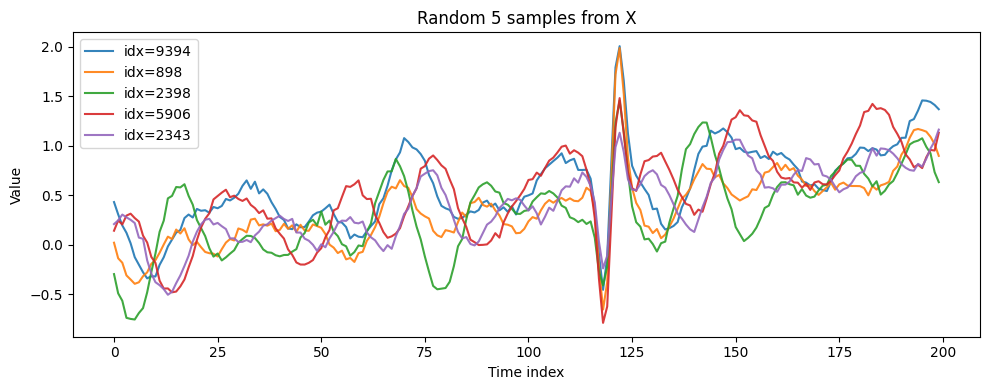


idx=9394  trend: intercept=0.103266, slope=0.004850
Top frequencies after detrend: (bin_k, k/T, period=T/k, amplitude)
  k=  5, f=0.025000, period=40.000, amp=24.701792
  k= 11, f=0.055000, period=18.182, amp=20.269897
  k=  8, f=0.040000, period=25.000, amp=14.459751
  k= 20, f=0.100000, period=10.000, amp=5.885831
  k= 19, f=0.095000, period=10.526, amp=5.583990

idx=898  trend: intercept=-0.113049, slope=0.004770
Top frequencies after detrend: (bin_k, k/T, period=T/k, amplitude)
  k= 11, f=0.055000, period=18.182, amp=18.245491
  k=  8, f=0.040000, period=25.000, amp=12.654320
  k=  5, f=0.025000, period=40.000, amp=10.956464
  k= 23, f=0.115000, period=8.696, amp=5.873425
  k= 19, f=0.095000, period=10.526, amp=5.830926

idx=2398  trend: intercept=-0.136148, slope=0.004648
Top frequencies after detrend: (bin_k, k/T, period=T/k, amplitude)
  k= 11, f=0.055000, period=18.182, amp=29.721098
  k=  8, f=0.040000, period=25.000, amp=24.475538
  k=  5, f=0.025000, period=40.000, amp=19.9

In [5]:
N = 10000
L = 200
X = generate_toy_dataset(N = N)
plot_toy_dataset(X,num = 5)
analyze_toy_dataset(X,num = 5)
analyze_season_ratio(X,num = 5)
out = summarize_X(X)
for k, v in out.items():
    print(f"{k}: {v}")
X = X.reshape(-1,1)
np.save(f"top_example_seq_{L}_sample_{N}.npy", X)

In [6]:
X.shape

(2000000, 1)